In [5]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist,mnist
from sklearn.model_selection import train_test_split
from scipy.special import log_softmax,softmax
import seaborn as sns

In [ ]:

def confusion_matrix(y_true, y_pred):

    classes = np.unique(y_true)
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for i in range(n_classes):
        for j in range(n_classes):
            cm[i, j] = np.sum((y_true == classes[i]) & (y_pred == classes[j]))

    return cm

def precision_score(y_true, y_pred, average='binary'):

    classes = np.unique(y_true)
    n_classes = len(classes)
    precision = np.zeros(n_classes)

    for i in range(n_classes):
        true_positive = np.sum((y_true == classes[i]) & (y_pred == classes[i]))
        false_positive = np.sum((y_true != classes[i]) & (y_pred == classes[i]))
        precision[i] = true_positive / (true_positive + false_positive)
    if average == 'binary':
        return precision[1]  
    elif average == 'micro':
        true_positive = np.sum(y_true == y_pred)
        false_positive = np.sum(y_true != y_pred)
        return true_positive / (true_positive + false_positive)
    elif average == 'macro':
        return np.mean(precision)
    elif average == 'weighted':
        class_count = np.bincount(y_true)
        weights = class_count / np.sum(class_count)
        return np.average(precision, weights=weights)
    else:
        raise ValueError("The 'average' parameter must be one of 'binary', 'micro', 'macro', or 'weighted'.")

In [2]:
class FFNN:
    def __init__(self,net_size,layer_act,init_wb='random',lr=1e-3,opt='rmsprop',lamda=0,batch_size=64,\
                 n_epochs=10,gamma=0.9,beta=0.999,beta_1=0.9,beta_2=0.999,seed=None,loss='cross_ent',relu_param=0,epsilon=1e-8):
        
        self.net_size = net_size
        self.layer_acts = layer_act
        self.init_wb = init_wb
        self.lr = lr
        self.optim = opt
        self.lamda = lamda
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.loss = loss
        self.seed = seed
        self.relu_param=relu_param
        self.gamma = gamma
        self.beta=beta
        self.epsilon=epsilon

    def onehot_encode(self,y, n_labels):
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.T
    
    def nn_init(self, network_size, wb_init='random'):

        if self.seed is not None:
            np.random.seed(self.seed)

        params = {}

        num_layers = len(network_size)

        if wb_init == 'random':
            for layer in range(1, num_layers):
                params['weights' + str(layer)] = np.random.normal(0,1,(network_size[layer], network_size[layer - 1]))
                params['biases' + str(layer)] = np.random.normal(0,1,(network_size[layer], 1))
                
        elif wb_init == 'xavier_uniform':
            for layer in range(1, num_layers):
                r = np.sqrt(6.0 / (network_size[layer] + network_size[layer - 1]))
                params['weights' + str(layer)] = np.random.uniform(-r, r, (network_size[layer], network_size[layer - 1]))
                params['biases' + str(layer)] = np.random.uniform(-r, r, (network_size[layer], 1))
        
        else:
            raise ValueError('Invalid Activation function ...')
        return params
    
    def Linear(self,input_data,diff=False):
        input_data = np.array(input_data, dtype=np.float64)
        if diff == False:
            return input_data
        else:
            return np.ones_like(input_data)

    def ReLU(self, input_data, diff=False):
        alpha = self.relu_param
        input_data = np.array(input_data, dtype=np.float64)

        if diff == False:
            return np.where(input_data < 0, alpha * input_data, input_data)

        elif diff == True:
            output_data = np.ones_like(input_data, dtype=np.float64)
            output_data[input_data < 0] = alpha
            return output_data
    
    # def ELU(self,input_data,diff=False):
    #     alpha = self.relu_param
    #     input_data = np.where(input_data>700,700,input_data)
    #     if diff == False:
    #         return np.where(input_data < 0, alpha * (np.exp(input_data)-1), input_data)
    #     else:
    #         output_data = np.ones_like(input_data, dtype=np.float64)
    #         output_data[input_data < 0] = alpha*np.exp(input_data)
    #         return output_data  
    
    def sigmoid(self, input_data, diff=False):
        input_data = np.where(input_data<-700,-700,input_data)
        if not diff:
            output_data = 1 / (1 + np.exp(-np.array(input_data)))
        else:
            s = 1 / (1 + np.exp(-np.array(input_data)))
            output_data = s * (1 - s)
        return output_data

    def Tanh(self, input_data, diff=False):
        input_data = np.array(input_data)
        input_data = np.clip(input_data,-700,700)
        if not diff:
            output_data = np.tanh(input_data)
        else:
            output_data = 1 - np.tanh(input_data) ** 2
        return output_data
    
    def softmax(self,X):
        X = np.clip(X,-700,700)
        return log_softmax(X,axis=0)

    def forward(self,data,acts,params):
        if self.seed is not None:
            np.random.seed(self.seed)
        param_list = []
        act_out = data
        for idx, act in enumerate(acts,start=1):
            data_prev = act_out
            Wb = np.dot(params['weights'+str(idx)],data_prev)+params['biases'+str(idx)]

            if act == 'sigmoid':
                act_out = self.sigmoid(Wb)
            elif act == 'tanh':
                act_out = self.Tanh(Wb)
            elif act == 'relu':
                act_out = self.ReLU(Wb)
            elif act == 'softmax':
                act_out = self.softmax(Wb)
            elif act == 'identity':
                act_out = self.Linear(Wb)
            # elif act == 'elu':
            #     act_out == self.ELU(Wb)
            else:
                raise ValueError('Invalid activation function ...')
            
            pl = ((data_prev,params['weights'+str(idx)],params['biases'+str(idx)]),Wb)
            param_list.append(pl)
        return act_out,param_list
    
    def grad(self,pred,target,params,lamda=0,loss='cross_ent'):
        n_class = target.shape[1]
        if loss == 'cross_ent':
            loss = -np.mean(np.multiply(pred,target),axis=1).sum()
        elif loss=='mse':
            loss = -np.mean(np.multiply(pred-target,pred-target),axis=1).sum()
        else:
            raise ValueError('Error function invalid. Please choose either "cross_ent" or "mse" ')
        param_len = len(params)//2

        sum_w = 0
        for idx in range(1,param_len):
            sum_w += np.square(params['weights'+str(idx)]).sum()
        loss += sum_w*(lamda/(2*n_class))
        return loss

    def backward(self,pred,target,param_list,acts,lamda=0,loss='cross_ent'):
        grad_tape = {}
        lpl = len(param_list)
        m,n = pred.shape
        target = target.reshape(pred.shape)
        if loss == 'cross_ent':
            dOut = np.exp(pred) - target
        elif loss == 'mse':
            dOut = 2*(np.exp(pred) - target)
        else:
            raise ValueError('Error function invalid. Please choose either "cross_ent" or "mse" ')

        pred,weight,_ = param_list[-1][0]
        grad_tape['d_weights'+str(lpl)] = np.dot(dOut,pred.T)/m
        grad_tape['d_biases'+str(lpl)] = dOut.sum(axis=1,keepdims=True)/m
        grad_tape['d_pred'+str(lpl-1)] = np.dot(weight.T,dOut)

        for idx in reversed(range(lpl-1)):
            linear_pred,out = param_list[idx]
            out_prev,weight,b = linear_pred

            m,n = out_prev.shape
            dOut_prev = grad_tape['d_pred'+str(idx+1)]

            if acts[idx] == 'relu':
                dOut = dOut_prev*self.ReLU(out,True)
            elif acts[idx] == 'sigmoid':
                dOut = dOut_prev*self.sigmoid(out,True)
            elif acts[idx] == 'tanh':
                dOut = dOut_prev*self.Tanh(out,True)
            # elif acts[idx] == 'elu':
            #     dOut = dOut_prev*self.ELU(out,True)
            elif acts[idx] == 'identity':
                dOut = dOut_prev*self.Linear(out,True)            
            
            grad_tape['d_pred'+str(idx)] = np.dot(weight.T,dOut)
            grad_tape['d_weights'+str(idx+1)] = (np.dot(dOut,out_prev.T)+ lamda*weight)/m
            grad_tape['d_biases'+str(idx+1)] = dOut.sum(axis=1,keepdims=True)/m
        return grad_tape
        

    def optim_step(self,params,grad_tape,lr,t_step,algo='adam',moment_params=None):
        len_param = len(params)//2

        if algo == 'sgd':
            for idx in range(len_param):
                params['weights'+str(idx+1)] -= lr*grad_tape['d_weights'+str(idx+1)]
                params['biases'+str(idx+1)] -= lr*grad_tape['d_biases'+str(idx+1)]
                moment_params=None
        elif algo == 'sgdm':
            for idx in range(len_param):
                moment_params['v_w'+str(idx+1)] = self.gamma*moment_params['v_w'+str(idx+1)] + (1-self.gamma)*grad_tape['d_weights'+str(idx+1)]
                moment_params['v_b'+str(idx+1)] = self.gamma*moment_params['v_b'+str(idx+1)] + (1-self.gamma)*grad_tape['d_biases'+str(idx+1)]

                params['weights'+str(idx+1)] -= lr*moment_params['v_w'+str(idx+1)]
                params['biases'+str(idx+1)] -= lr*moment_params['v_b'+str(idx+1)]
        elif algo == 'nag':
            for idx in range(len_param):
                moment_params['v_w'+str(idx+1)] = self.gamma*moment_params['v_w'+str(idx+1)] - lr*grad_tape['d_weights'+str(idx+1)]
                moment_params['v_b'+str(idx+1)] = self.gamma*moment_params['v_b'+str(idx+1)] - lr*grad_tape['d_biases'+str(idx+1)]

                params['weights'+str(idx+1)] -= self.gamma*(moment_params['v_w'+str(idx+1)] - moment_params['v_w_prev'+str(idx+1)])
                params['biases'+str(idx+1)] -= self.gamma*(moment_params['v_b'+str(idx+1)] - moment_params['v_b_prev'+str(idx+1)])

                moment_params['v_w_prev'+str(idx+1)] = moment_params['v_w'+str(idx+1)]
                moment_params['v_b_prev'+str(idx+1)] = moment_params['v_b'+str(idx+1)]

        elif algo == 'rmsprop':
            for idx in range(len_param):
                moment_params['m_b'+str(idx+1)] = self.beta*moment_params['m_b'+str(idx+1)] + (1-self.beta)*(grad_tape['d_biases'+str(idx+1)]**2)
                moment_params['m_w'+str(idx+1)] = self.beta*moment_params['m_w'+str(idx+1)] + (1-self.beta)*(grad_tape['d_weights'+str(idx+1)]**2)

                params['weights'+str(idx+1)] -= lr*grad_tape['d_weights'+str(idx+1)]/(np.sqrt(moment_params['m_w'+str(idx+1)])+self.epsilon)
                params['biases'+str(idx+1)] -= lr*grad_tape['d_biases'+str(idx+1)]/(np.sqrt(moment_params['m_b'+str(idx+1)])+self.epsilon)

        elif algo == 'adam':
            for idx in range(len_param):
                moment_params['v_b'+str(idx+1)] = self.beta_1*moment_params['v_b'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_biases'+str(idx+1)]
                moment_params['v_w'+str(idx+1)] = self.beta_1*moment_params['v_w'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_weights'+str(idx+1)]

                moment_params['m_b'+str(idx+1)] = self.beta_2*moment_params['m_b'+str(idx+1)] + (1-self.beta_2)*(grad_tape['d_biases'+str(idx+1)]**2)
                moment_params['m_w'+str(idx+1)] = self.beta_2*moment_params['m_w'+str(idx+1)] + (1-self.beta_2)*(grad_tape['d_weights'+str(idx+1)]**2)

                mod_lr = lr*np.sqrt((1-self.beta_2**t_step)/(1-self.beta_1**t_step+self.epsilon))
                params['weights'+str(idx+1)] -= mod_lr*(moment_params['v_w'+str(idx+1)]/(np.sqrt(moment_params['m_w'+str(idx+1)])+self.epsilon))
                params['biases'+str(idx+1)] -= mod_lr*(moment_params['v_b'+str(idx+1)]/(np.sqrt(moment_params['m_b'+str(idx+1)])+self.epsilon))
        elif algo =='nadam':
            for idx in range(len_param):
                moment_params['v_b'+str(idx+1)] = self.beta_1*moment_params['v_b'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_biases'+str(idx+1)]
                moment_params['v_w'+str(idx+1)] = self.beta_1*moment_params['v_w'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_weights'+str(idx+1)]

                moment_params['m_b'+str(idx+1)] = self.beta_2*moment_params['m_b'+str(idx+1)] + (1-self.beta_2)*(grad_tape['d_biases'+str(idx+1)]**2)
                moment_params['m_w'+str(idx+1)] = self.beta_2*moment_params['m_w'+str(idx+1)] + (1-self.beta_2)*(grad_tape['d_weights'+str(idx+1)]**2)

                mod_lr = lr*np.sqrt((1-self.beta_2**t_step)/(1-self.beta_1**t_step+self.epsilon))
                params['weights'+str(idx+1)] -= (mod_lr/(np.sqrt(moment_params['m_w'+str(idx+1)])+self.epsilon))*(self.beta_1*moment_params['v_w'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_weights'+str(idx+1)])
                params['biases'+str(idx+1)] -= (mod_lr/(np.sqrt(moment_params['m_b'+str(idx+1)])+self.epsilon))*(self.beta_1*moment_params['v_b'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_biases'+str(idx+1)])
        return params,moment_params
    
    def predict(self,data):
        out = self.forward(data,self.layer_acts,self.params)[0]
        return np.argmax(out,axis=0),out.T
    
    def train(self,X_train,Y_train,X_val,Y_val,n_classes=10,wb_log=True):
        self.losses=[]
        moment_params = {}
        m = X_train.shape[1]
        y_train = self.onehot_encode(Y_train,n_classes)
        y_val = self.onehot_encode(Y_val,n_classes)
        self.params = self.nn_init(self.net_size,self.init_wb)
        self.t_step = 1
        idx = np.arange(m)

        if self.optim != 'sgd':
            for ii in range(1,len(self.net_size)):
                moment_params['v_w'+str(ii)] = np.zeros((self.net_size[ii],self.net_size[ii-1]))
                moment_params['v_b'+str(ii)] = np.zeros((self.net_size[ii],1))

                moment_params['v_w_prev'+str(ii)] = np.zeros((self.net_size[ii],self.net_size[ii-1]))
                moment_params['v_b_prev'+str(ii)] = np.zeros((self.net_size[ii],1))

                moment_params['m_w'+str(ii)] = np.zeros((self.net_size[ii],self.net_size[ii-1]))
                moment_params['m_b'+str(ii)] = np.zeros((self.net_size[ii],1))
        
        for _ in range(self.n_epochs):
            np.random.shuffle(idx)
            X_shuffled = X_train[:,idx]
            Y_shuffled = y_train[:,idx]
            for ii in range(0,m,self.batch_size):
                X_batched = X_shuffled[:,ii:ii+self.batch_size]
                Y_batched = Y_shuffled[:,ii:ii+self.batch_size]

                out,param_list = self.forward(X_batched,self.layer_acts,self.params)                
                loss = self.grad(out,Y_batched,self.params,self.lamda,self.loss)                
                self.losses.append(loss)
                grads = self.backward(out,Y_batched,param_list,self.layer_acts,self.lamda,self.loss)
                self.params,moment_params = self.optim_step(self.params,grads,self.lr,\
                                                            self.t_step,self.optim,moment_params)
                self.t_step+=1
            y_pred_train,_ = self.predict(X_train)
            y_pred_valid,_ = self.predict(X_val)

            train_acc = accuracy_score(Y_train,y_pred_train)
            val_acc = accuracy_score(Y_val,y_pred_valid)
            val_out,_ = self.forward(X_val,self.layer_acts,self.params)
            val_loss = self.grad(val_out,y_val,self.params,self.lamda,self.loss)
            log = {'train_acc':train_acc, 'val_acc':val_acc,'train_loss':loss,'val_loss':val_loss}#
            if wb_log:
                wandb.log(log)
            else:
                print(log)

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

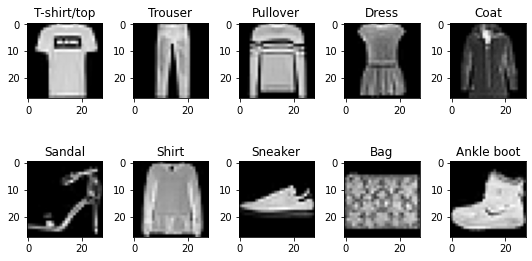

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_num = 10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
img_list=[]
for i in range(class_num):
  ax = axes[i//num_col, i%num_col]
  a = np.argmax(y_train == i)
  ax.imshow(x_train[a], cmap='gray')
  ax.set_title(class_names[i])
plt.tight_layout()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0, stratify=y_train)

x_train = x_train.reshape((len(x_train), 28*28))
x_train = x_train.astype('float32') / 255

x_valid = x_valid.reshape((len(x_valid), 28*28))
x_valid = x_valid.astype('float32') / 255

# Preprocessing test data
x_test = x_test.reshape((len(x_test), 28 * 28))
x_test = x_test.astype('float32') / 225

In [5]:
X = x_train.T
X_valid = x_valid.T
Y_valid = y_valid
Y = y_train
n_class= 10
n_hidden = 4
layers = []
hidden_size=32
for i in range(n_hidden+2):
    if i == 0:
        layers.append(X.shape[0])
    elif i == n_hidden+1:
        layers.append(n_class)
    else:
        layers.append(hidden_size)
    i = i+1
act = []
o_act = 'softmax'
actvn_fn = 'identity'
for i in range(n_hidden+1):
    if i == n_hidden:
        act.append(o_act)
    else:
        act.append(actvn_fn)
    i = i+1
model = FFNN(layers,act,'xavier_uniform',opt='adam')

In [6]:
# model.params = model.nn_init(layers)
# model.train(X,Y,X_valid,Y_valid,wb_log=False)
# y_pred,_ = model.predict(x_test.T)

In [7]:
sweep_config = {
    'method':'bayes',
    'metric':{
    'name':'val_acc',
    'goal':'maximize'
    },
    'parameters':{
    'n_epochs':{
    'values':[5,10]
    },
    'n_hidden':{
    'values':[3,4,5]
    },
    'n_hidden_units':{
    'values':[32,64,128]
    },
    'l2_coeff':{
    'values':[0,5e-4,5e-1]
    },
    'lr':{
    'values':[1e-3,1e-4]
    },
    'optim_algo':{
    'values':['sgd','sgdm','rmsprop','adam','nadam','nag']
    },
    'batch_size':{
    'values':[16,32,64]
    },
    'weights_init':{
    'values':['random','xavier_uniform']
    },
    'act_func':{
    'values':['relu','sigmoid','tanh','identity']
    },
    'loss_func':{
    'values':['cross_ent','mse']
    },
    'relu_param':{
    'values':[0,1e-1,1e-2,1e-3]
    }
    }
}


In [8]:
sweep_id = wandb.sweep(sweep_config, entity="viswa_ee", project="CS6910")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 5hrjihf5
Sweep URL: https://wandb.ai/viswa_ee/CS6910/sweeps/5hrjihf5


In [9]:
def learn():
    config_defaults={
        'n_epochs':10,
        'n_hidden':3,
        'n_hidden_units':10,
        'l2_coeff':0,
        'lr':1e-3,
        'optim_algo':'sgd',
        'batch_size':16,
        'weights_init':'random',
        'act_func':'relu',
        'loss_func':'cross_ent',
        'relu_param':0
    }
    wandb.init(config=config_defaults)
    config = wandb.config
    X = x_train.T
    X_valid = x_valid.T
    Y_valid = y_valid
    Y = y_train
    n_class= 10
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    layers = []
    for i in range(config.n_hidden+2):
        if i == 0:
            layers.append(X.shape[0])
        elif i == config.n_hidden+1:
            layers.append(n_class)
        else:
            layers.append(config.n_hidden_units)
        i = i+1
    
    output_act = 'softmax'
    act_fn = config.act_func

    acts = []
    for i in range(config.n_hidden+1):
        if i == config.n_hidden:
            acts.append(output_act)
        else:
            acts.append(act_fn)
        i = i+1
    
    wandb.run.name = config.weights_init+'_'+ config.optim_algo +'_'+ config.act_func + '_bs_' + str(config.batch_size)+'_layers_'+str(config.n_hidden)+'_neurons_'+str(config.n_hidden_units)
    model = FFNN(net_size=layers,layer_act=acts,init_wb=config.weights_init,lr=config.lr,opt=config.optim_algo,\
                 lamda=config.l2_coeff,batch_size=config.batch_size,n_epochs=config.n_epochs,loss=config.loss_func,relu_param=config.relu_param)
    model.train(X,Y,X_valid,Y_valid)
    y_test_pred,_ = model.predict(x_test.T)
    cm = confusion_matrix(y_test, y_test_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm_norm, annot=True, cmap="Blues", square=True, xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    # Log the confusion matrix plot to wandb
    wandb.log({"Confusion Matrix":wandb.Image(fig)})
    fig.clf()
    plt.close('all')
    # log = {'conf_matrix':wandb.plot.confusion_matrix(y_true=y_test,preds=y_test_pred,class_names=class_names)}
    # wandb.log(log)
    # wandb.log({'conf_mat_'+wandb.run.name:wandb.plot.confusion_matrix(y_true=y_test,preds=y_test_pred,class_names=class_names)})
    

In [10]:
wandb.agent(sweep_id,learn,count=60)

wandb: Agent Starting Run: xcrk1fqa with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.001
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: viswa_ee. Use `wandb login --relogin` to force relogin


train_acc,▅▆▇▆▁▇██▇█
train_loss,▂▁▃▃▆▇▄█▅▄
val_acc,▅▆▇▆▁▇██▇█
val_loss,▄▃▁▃█▁▁▁▂▁
train_acc,0.8538
train_loss,0.49757
val_acc,0.8465
val_loss,0.44533


wandb: Agent Starting Run: t62dnstb with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▅▂▄▃▂▃▁▂▁
val_acc,▁▃▄▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
train_acc,0.49607
train_loss,2.0091
val_acc,0.475
val_loss,3.94171


wandb: Agent Starting Run: hek1wzia with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁█▂▇▂▆▇███
train_loss,▅▁▄▇▃▄▂█▅▂
val_acc,▂█▂▆▁▆▇▆▇▇
val_loss,▆▄▅▇▆▃▁█▄▅
train_acc,0.08567
train_loss,-72.9421
val_acc,0.09217
val_loss,-72.469


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d4q6v8fj with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.1
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Network error (ConnectionError), entering retry loop.


train_acc,▁▂▂▃▄▅▆▇▇█
train_loss,▁▇▇█▆▇▆▇█▆
val_acc,▁▂▃▄▄▅▆▇▇█
val_loss,▁▇▇███████
train_acc,0.2825
train_loss,-181.8052
val_acc,0.2735
val_loss,-151.63111


wandb: Agent Starting Run: 42nubn62 with config:
wandb: 	act_func: relu
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.01
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▆▅██
train_loss,▁▅▃▇█
val_acc,▁▆▅▇█
val_loss,▁▅▆▇█
train_acc,0.55035
train_loss,-23.19866
val_acc,0.54817
val_loss,-507.74044


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4w08kvb9 with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.001
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▂▂▃▄▅▆▇█
train_loss,▁▄▅▇▇██▇▆▇
val_acc,▁▂▂▃▃▄▅▆▇█
val_loss,▁▄▆▇▇███▇▇
train_acc,0.20676
train_loss,-57.98144
val_acc,0.21183
val_loss,-59.0002


wandb: Agent Starting Run: bsxztiqb with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▆▁▆█▃
train_loss,▆▅█▅▁
val_acc,▆▁▆█▂
val_loss,▄█▅▁▄
train_acc,0.80843
train_loss,0.57699
val_acc,0.802
val_loss,0.53864


wandb: Agent Starting Run: b59na5c9 with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.01
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▄█▃▁▁▆▆▁▆▅
train_loss,▁▄▃▅▅▃█▄▃▅
val_acc,▃▄▅▄█▃▄▁▆▅
val_loss,▅▅▅██▃▇▇▅▁
train_acc,0.10433
train_loss,-4861.71267
val_acc,0.10117
val_loss,-5202.58429


wandb: Agent Starting Run: d08zs73e with config:
wandb: 	act_func: relu
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: sgd
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▄▅▆▇▇▇██
train_loss,████▇▇▇▆▄▁
val_acc,▁▂▄▅▆▇▇▇██
val_loss,█████▇▆▅▄▁
train_acc,0.52452
train_loss,-69.80124
val_acc,0.52167
val_loss,-69.09015


wandb: Agent Starting Run: 1q971row with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: sgd
wandb: 	relu_param: 0.001
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▇█
train_loss,█▆▄▁▁
val_acc,▁▄▆▇█
val_loss,█▆▄▂▁
train_acc,0.33276
train_loss,1.98202
val_acc,0.32983
val_loss,1.91704


wandb: Agent Starting Run: g5h22lzr with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▄▅▆▆▇▇▇█
train_loss,█▇▅▅▄▄▁▁▃▃
val_acc,▁▁▄▆▇▆▇▇▇█
val_loss,█▆▅▅▄▃▃▂▂▁
train_acc,0.8978
train_loss,-643.98923
val_acc,0.881
val_loss,-737.39656


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jwglf2lu with config:
wandb: 	act_func: relu
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▁▆▁▃▃▄▁
val_acc,▁▅▆▆▇▇▇███
val_loss,█▂▂▂▂▁▂▂▂▂
train_acc,0.67289
train_loss,969.4168
val_acc,0.67267
val_loss,68.23546


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lp1b9vd7 with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▇▇█
train_loss,█▅▃▃▁
val_acc,▁▅▇██
val_loss,█▆▄▂▁
train_acc,0.88083
train_loss,-661.05691
val_acc,0.87183
val_loss,-694.73446


wandb: Agent Starting Run: trp6c52f with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.001
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆▇█
train_loss,█▇▅▄▁
val_acc,▁▅▆▇█
val_loss,█▇▅▃▁
train_acc,0.70463
train_loss,-220.09011
val_acc,0.698
val_loss,-209.32405


wandb: Agent Starting Run: ljk7vy18 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▆▇▇▇███
train_loss,█▄▃▂▃▄▃▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▃▃▂▂▂▁▁▁
train_acc,0.77665
train_loss,1.8143
val_acc,0.77317
val_loss,0.65771


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mldam7et with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.001
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆██
train_loss,█▇▆▆▁
val_acc,▁▃▆▇█
val_loss,█▆▅▄▁
train_acc,0.86015
train_loss,-1967.68749
val_acc,0.85167
val_loss,-1783.40304


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2jtwpjla with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁█▄▆▆▁▂█▅█
train_loss,█▅▄▃▂▁▁▁▂▁
val_acc,▂▇▃▆▆▁▂█▅▇
val_loss,█▁▅▂▂▅▆▁▄▁
train_acc,0.83787
train_loss,0.68728
val_acc,0.83133
val_loss,0.48205


wandb: Agent Starting Run: 6eb0qrk0 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▄▆▄▆▅▇█▇
train_loss,██▅▆▂▃▄▅▁▂
val_acc,▃▁▄▆▃▅▅▅█▇
val_loss,█▇▅▄▄▄▂▁▁▁
train_acc,0.861
train_loss,-2051.18477
val_acc,0.85033
val_loss,-2021.13457


wandb: Agent Starting Run: 0rel6u9x with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆█▆█▆▇██
train_loss,█▆▅▄▃▂▂▂▁▂
val_acc,▁▅▅▇▅█▆▆██
val_loss,█▅▃▂▃▂▃▂▁▁
train_acc,0.85093
train_loss,1.26438
val_acc,0.8475
val_loss,0.4475


wandb: Agent Starting Run: dznzrxlx with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▂▅▇▇█▅▃█
train_loss,█▇▅▄▃▂▂▁▂▂
val_acc,▂▂▁▄▇██▅▂▆
val_loss,█▇▆▃▂▁▁▂▄▁
train_acc,0.85061
train_loss,0.99749
val_acc,0.84283
val_loss,0.44951


wandb: Agent Starting Run: ki6sxppr with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▅▆▆▇▆▇▇█
train_loss,█▇▃▅▅▃▃▄▃▁
val_acc,▁▅▆▇▇█▆█▇█
val_loss,█▆▅▃▃▃▂▂▂▁
train_acc,0.86224
train_loss,-2248.55798
val_acc,0.851
val_loss,-2257.7403


wandb: Agent Starting Run: dnj36weo with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▆▄█▇
train_loss,█▆▄▂▁
val_acc,▁▅▄▇█
val_loss,█▄▄▁▁
train_acc,0.84531
train_loss,1.6158
val_acc,0.8425
val_loss,0.46641


wandb: Agent Starting Run: kgjx3xnk with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▆▅▅▆▅█▄
train_loss,█▅▃▂▂▂▂▁▁▂
val_acc,▁▇█▇▄▆▄▄▇▄
val_loss,█▃▃▃▃▁▂▂▁▄
train_acc,0.8325
train_loss,1.48681
val_acc,0.82733
val_loss,0.49998


wandb: Agent Starting Run: 7asu2sj0 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆█▆
train_loss,█▆▄▃▁
val_acc,▁▆▇█▇
val_loss,█▄▃▁▁
train_acc,0.84639
train_loss,-1363.53673
val_acc,0.84367
val_loss,-1193.69658


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f2hhzmoj with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▆▆▇▆███
train_loss,█▆▄▄▂▃▃▁▁▁
val_acc,▁▅▅▆▇█▆███
val_loss,█▆▅▄▃▂▂▂▁▁
train_acc,0.85887
train_loss,-2134.25441
val_acc,0.85217
val_loss,-2105.6702


wandb: Agent Starting Run: 90oizpox with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▆█
train_loss,▅▂██▁
val_acc,▁▃▅▅█
val_loss,█▄▃▁▂
train_acc,0.86233
train_loss,-2199.26718
val_acc,0.8565
val_loss,-1693.61638


wandb: Agent Starting Run: ry5075s1 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▆▆▆██▇▇▆▆
train_loss,▇▅▅▄▆▁█▂▂▃
val_acc,▁▆▆▄█▇▇▆▄▄
val_loss,██▇▅▆▄▄▂▃▁
train_acc,0.8297
train_loss,-939.25716
val_acc,0.82033
val_loss,-1011.83569


wandb: Agent Starting Run: zk5otmul with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁█▇▅▁
train_loss,▅▄▄█▁
val_acc,▂█▇▄▁
val_loss,█▅▁▄▃
train_acc,0.83656
train_loss,-1072.66763
val_acc,0.82917
val_loss,-961.35853


wandb: Agent Starting Run: w60fxw0u with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,█▇▅▁▅
train_loss,█▁▁▃█
val_acc,██▁█▁
val_loss,▂▁▃▂█
train_acc,0.10635
train_loss,-61.38353
val_acc,0.10317
val_loss,-74.77847


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ap8y4qs0 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▆▇▇▇███
train_loss,██▇▆▆▃▃▂▁▄
val_acc,▁▄▅▆▇▇████
val_loss,█▇▇▆▅▄▃▃▂▁
train_acc,0.72867
train_loss,-172.54003
val_acc,0.71967
val_loss,-280.92005


wandb: Agent Starting Run: 84wl8nq2 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: adam
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▅▆▆▇███
train_loss,▇▅█▇▃▃█▁▄█
val_acc,▁▄▆▅▆▆▇▇██
val_loss,█▄▅▅▄▄▃▁▂▁
train_acc,0.83881
train_loss,-726.4714
val_acc,0.83483
val_loss,-867.33059


wandb: Agent Starting Run: 7tv2hdlm with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅██▇
train_loss,█▆▃▂▁
val_acc,▁▆███
val_loss,█▅▃▂▁
train_acc,0.8462
train_loss,-1856.89651
val_acc,0.84117
val_loss,-1655.93436


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 97uu3d07 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▇▇▆▇███
train_loss,█▅▆▅▆▄▅▃▃▁
val_acc,▁▅▅▇█▆▇███
val_loss,█▆▅▄▃▃▃▂▂▁
train_acc,0.86165
train_loss,-3100.64671
val_acc,0.85517
val_loss,-2284.46118


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ozom9imt with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▇▇▄█
train_loss,█▅▃▃▁
val_acc,▁▇▇▆█
val_loss,█▃▂▃▁
train_acc,0.8483
train_loss,1.19577
val_acc,0.84417
val_loss,0.45867


wandb: Agent Starting Run: 2hmb3yv9 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▆▇▇▆█▇█
train_loss,█▄▄▁▁▁▂▃▁▂
val_acc,▁▅▆▆▇▆▆▇▇█
val_loss,█▅▄▂▃▂▂▁▁▁
train_acc,0.86057
train_loss,-1252.6596
val_acc,0.854
val_loss,-1289.36251


wandb: Agent Starting Run: 661nbjro with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆▇▆▆▇▇▇█
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▅▇▇▇▆▇▇██
val_loss,█▄▃▂▂▃▂▂▂▁
train_acc,0.85393
train_loss,0.91554
val_acc,0.8475
val_loss,0.44126


wandb: Agent Starting Run: cv1gs7q0 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▇▇█▆▆▇▇█
train_loss,▄█▁▂▃▄▂▅▄▄
val_acc,▁▃▇▆▆▆▆▇▇█
val_loss,█▅▅▄▃▂▂▂▁▁
train_acc,0.85217
train_loss,-859.92527
val_acc,0.84733
val_loss,-953.17428


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4pkh01lw with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.001
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▂▅▄▁▇▃▅▂█▃
train_loss,▂▇▃▃█▅▁▅▇▆
val_acc,▄▄▅▂▇█▇▁▄▄
val_loss,█▄▇█▇▄▂█▇▁
train_acc,0.15235
train_loss,-67.34895
val_acc,0.1495
val_loss,-76.20949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zkxy0owz with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: adam
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▆▆▇█▆▇█
train_loss,█▇▅▂▄▃▁▃▄▁
val_acc,▁▄▅▆▇▇█▆▇█
val_loss,█▆▅▄▃▃▂▂▁▁
train_acc,0.86437
train_loss,-2717.7726
val_acc,0.855
val_loss,-2376.85634


wandb: Agent Starting Run: j2znwrub with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▂█▇▁▁▃▄█▁▇
train_loss,█▄▃▃▂▂▄▁▁▃
val_acc,▃▇█▁▂▄▁█▄▇
val_loss,█▃▂▅▅▄▃▂▅▁
train_acc,0.81352
train_loss,1.05678
val_acc,0.80767
val_loss,0.5565


wandb: Agent Starting Run: zcdqkwra with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆▇▇▇████
train_loss,█▇▇▆▅▅▃▄▂▁
val_acc,▁▅▆▆▇▇████
val_loss,█▇▇▆▅▄▃▂▂▁
train_acc,0.73091
train_loss,-291.86951
val_acc,0.71933
val_loss,-286.16291


wandb: Agent Starting Run: jcewn2ds with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▅█
train_loss,█▆▄▂▁
val_acc,▁▄▇▆█
val_loss,█▅▄▂▁
train_acc,0.84837
train_loss,-339.19894
val_acc,0.84267
val_loss,-353.825


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 17mk8gig with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▇██
train_loss,█▆▅▁▂
val_acc,▁▅▇██
val_loss,█▇▅▃▁
train_acc,0.63648
train_loss,-128.29763
val_acc,0.63017
val_loss,-151.61482


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sg23uhzi with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▃▇▆▆▆█▇▇
train_loss,▆▅▅▂▄▂█▂▁█
val_acc,▁▄▄▇█▆▆██▇
val_loss,▅▆▅█▅▂▃▂▄▁
train_acc,0.85007
train_loss,-706.89187
val_acc,0.8435
val_loss,-1007.93139


wandb: Agent Starting Run: vsnkz9av with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆▆▆▇▇▇██
train_loss,▅▁▂▇▄▂▄▄█▄
val_acc,▁▅▇▇▇▇▇▆██
val_loss,█▄▃▂▃▂▂▂▁▁
train_acc,0.86243
train_loss,0.41608
val_acc,0.85517
val_loss,0.41439


wandb: Agent Starting Run: h9awkp8e with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: nag
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▇▄▃▆▂▁▅▃▄█
train_loss,▇▄▅▅▅█▁▇▃▆
val_acc,█▁▇▇▂█▄▂▅▇
val_loss,██▁▇▇▆▅▅▅▄
train_acc,0.12319
train_loss,3.54318
val_acc,0.12183
val_loss,2.5252


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: prn9nzrb with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▆▆▃▇▇▃██▇
train_loss,█▅▄▃▂▂▂▁▂▁
val_acc,▂▆▆▁▇▆▁█▇█
val_loss,█▄▃▄▂▂▅▂▁▁
train_acc,0.85035
train_loss,0.67992
val_acc,0.84683
val_loss,0.44572


wandb: Agent Starting Run: y4xl2ats with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▆▆▃▆█▆▅▇▆
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▆▇▂▆█▇▅█▄
val_loss,█▄▃▄▃▁▃▃▁▂
train_acc,0.83348
train_loss,1.02817
val_acc,0.82583
val_loss,0.49456


wandb: Agent Starting Run: 7ikgzlw5 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▃▆▆▆▅█▁▇██
train_loss,▆▇▇▄▆█▆▁▅▄
val_acc,▃▇▅█▅█▁▇██
val_loss,███▄▄▅▃▁▁▂
train_acc,0.83511
train_loss,-1059.2052
val_acc,0.8285
val_loss,-933.6451


wandb: Agent Starting Run: 9ryz4an1 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▇██
train_loss,█▄▆▂▁
val_acc,▁▆▇██
val_loss,█▅▃▂▁
train_acc,0.84631
train_loss,-1622.41352
val_acc,0.83917
val_loss,-1584.03367


wandb: Agent Starting Run: w22u73vo with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▄▁▇▇▆▇▇██▇
train_loss,▇▇▆▇█▄▅▁▄▅
val_acc,▅▁█▆▆▇█▇█▇
val_loss,█▇▆▅▄▄▃▁▁▁
train_acc,0.83754
train_loss,-790.0185
val_acc,0.83367
val_loss,-829.09849


wandb: Agent Starting Run: wfrrbfvu with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▆▅▇▇███
train_loss,██▅▁▅▃▄▅▆▄
val_acc,▁▄▆▆▅▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
train_acc,0.8575
train_loss,-1788.66841
val_acc,0.85033
val_loss,-2133.17646


wandb: Agent Starting Run: y20rq1j5 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▆██
train_loss,█▇▅▂▁
val_acc,▁▅▆█▇
val_loss,█▅▄▂▁
train_acc,0.85615
train_loss,-1875.52397
val_acc,0.8475
val_loss,-1791.54609


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0j931xd5 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▆▆▆█
train_loss,██▁▅▁
val_acc,▁▇▆▅█
val_loss,█▅▄▃▁
train_acc,0.85748
train_loss,-1969.76568
val_acc,0.85083
val_loss,-1778.06676


wandb: Agent Starting Run: e0fg6qye with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▄▇▇▆███
train_loss,█▇▅▅▆▆▂▂▁▄
val_acc,▁▅▅▄▇▇▆█▇█
val_loss,█▆▅▄▃▂▂▂▁▁
train_acc,0.8635
train_loss,-1845.39856
val_acc,0.85667
val_loss,-2183.82441


wandb: Agent Starting Run: xu1qrq30 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: sgd
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▆▅▅▅▃▃▁▂
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
train_acc,0.79281
train_loss,9.31158
val_acc,0.788
val_loss,0.62149


wandb: Agent Starting Run: ohslqv0p with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: sgd
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▇█
train_loss,█▇▆▃▁
val_acc,▁▄▆▇█
val_loss,█▇▆▄▁
train_acc,0.59857
train_loss,-151.451
val_acc,0.591
val_loss,-144.45123


wandb: Agent Starting Run: hocrhrtj with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▆█▃▄▁
train_loss,█▇▁▂▃
val_acc,▇█▄▅▁
val_loss,▇█▆▅▁
train_acc,0.09422
train_loss,2.87823
val_acc,0.09267
val_loss,2.92145


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6wzrfvan with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▅▇█
train_loss,█▁▆▅▁
val_acc,▁▂▆▆█
val_loss,█▅▄▁▁
train_acc,0.85798
train_loss,-1522.44476
val_acc,0.8545
val_loss,-1667.89769


wandb: Agent Starting Run: dw6pdzed with config:
wandb: 	act_func: identity
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.1
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▄▆▇███▇
train_loss,█▅▅█▇▅▄▅▃▁
val_acc,▁▄▅▄▇▇▇██▇
val_loss,█▆▅▅▃▃▂▂▂▁
train_acc,0.85865
train_loss,-2312.49482
val_acc,0.84783
val_loss,-2267.80451


In [6]:
class_names = [str(i) for i in range(10)]

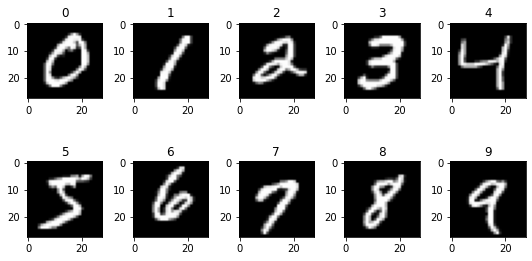

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_num = 10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
img_list=[]
for i in range(class_num):
  ax = axes[i//num_col, i%num_col]
  a = np.argmax(y_train == i)
  ax.imshow(x_train[a], cmap='gray')
  ax.set_title(class_names[i])
plt.tight_layout()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0, stratify=y_train)

x_train = x_train.reshape((len(x_train), 28*28))
x_train = x_train.astype('float32') / 255

x_valid = x_valid.reshape((len(x_valid), 28*28))
x_valid = x_valid.astype('float32') / 255

# Preprocessing test data
x_test = x_test.reshape((len(x_test), 28 * 28))
x_test = x_test.astype('float32') / 225

In [8]:
sweep_config = {
    'method':'bayes',
    'metric':{
    'name':'val_acc',
    'goal':'maximize'
    },
    'parameters':{
    'optim_algo':{
    'values':['sgd','sgdm','rmsprop','adam','nadam','nag']
    },
    'weights_init':{
    'values':['random','xavier_uniform']
    },
    'act_func':{
    'values':['relu','sigmoid','tanh','identity']
    }
    }
}

In [11]:
sweep_id = wandb.sweep(sweep_config, entity="viswa_ee", project="CS6910")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: faldzlw8
Sweep URL: https://wandb.ai/viswa_ee/CS6910/sweeps/faldzlw8


In [9]:
def learn():
    config_defaults={
        'optim_algo':'adam',
        'weights_init':'xavier_uniform',
        'act_fn':'relu'
    }
    wandb.init(config=config_defaults)
    config = wandb.config
    X = x_train.T
    X_valid = x_valid.T
    Y_valid = y_valid
    Y = y_train
    n_class= 10
    class_names = [str(i) for i in range(10)]

    layers = []
    n_hidden = 5
    n_hidden_units = 64
    for i in range(n_hidden+2):
        if i == 0:
            layers.append(X.shape[0])
        elif i == n_hidden+1:
            layers.append(n_class)
        else:
            layers.append(n_hidden_units)
        i = i+1
    
    output_act = 'softmax'
    act_fn = 'tanh'

    acts = []
    for i in range(n_hidden+1):
        if i == n_hidden:
            acts.append(output_act)
        else:
            acts.append(act_fn)
        i = i+1
    
    wandb.run.name = config.weights_init+'_'+ config.optim_algo +'_'+ config.act_func 
    model = FFNN(net_size=layers,layer_act=acts,init_wb=config.weights_init,lr=0.0001,opt=config.optim_algo,\
                 lamda=0,batch_size=16,n_epochs=10,loss='mse',relu_param=0)
    model.train(X,Y,X_valid,Y_valid)
    y_test_pred,_ = model.predict(x_test.T)
    cm = confusion_matrix(y_test, y_test_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm_norm, annot=True, cmap="Blues", square=True, xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    # Log the confusion matrix plot to wandb
    wandb.log({"Confusion Matrix":wandb.Image(fig)})
    fig.clf()
    plt.close('all')
    # log = {'conf_matrix':wandb.plot.confusion_matrix(y_true=y_test,preds=y_test_pred,class_names=class_names)}
    # wandb.log(log)
    # wandb.log({'conf_mat_'+wandb.run.name:wandb.plot.confusion_matrix(y_true=y_test,preds=y_test_pred,class_names=class_names)})
    

In [12]:
wandb.agent(sweep_id,learn,count=20)

wandb: Agent Starting Run: osc47dxh with config:
wandb: 	act_func: sigmoid
wandb: 	optim_algo: sgd
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: viswa_ee. Use `wandb login --relogin` to force relogin


train_acc,▁▃▄▅▅▆▇▇██
train_loss,████▇▆▆▄▃▁
val_acc,▁▃▄▅▅▆▇▇██
val_loss,███▇▇▆▅▄▃▁
train_acc,0.61033
train_loss,-98.47681
val_acc,0.60367
val_loss,-90.30037


wandb: Agent Starting Run: j8uc78lf with config:
wandb: 	act_func: relu
wandb: 	optim_algo: sgdm
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▄▅▆▇▇▇██
train_loss,████▇▆▅▃▄▁
val_acc,▁▂▄▅▆▇▇▇██
val_loss,████▇▇▆▄▃▁
train_acc,0.6232
train_loss,-85.72391
val_acc,0.62583
val_loss,-88.57078


wandb: Agent Starting Run: gsdsnki0 with config:
wandb: 	act_func: sigmoid
wandb: 	optim_algo: adam
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▆▆▄▃▃▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▇▆▅▄▄▃▂▁▁
train_acc,0.98256
train_loss,-1009.84143
val_acc,0.966
val_loss,-1011.10565


wandb: Agent Starting Run: yke8gmtz with config:
wandb: 	act_func: sigmoid
wandb: 	optim_algo: nadam
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▆▆▇▇▇██
train_loss,█▆▆▆▄▃▂▃▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▇▆▅▄▄▃▂▂▁
train_acc,0.98257
train_loss,-984.17706
val_acc,0.9685
val_loss,-998.68206


wandb: Agent Starting Run: 6bhflad2 with config:
wandb: 	act_func: identity
wandb: 	optim_algo: nadam
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▆▆▇▇███
train_loss,█▇▆▅▅▄▃▃▂▁
val_acc,▁▄▅▅▆▇█▇██
val_loss,█▇▆▅▅▄▃▃▂▁
train_acc,0.98276
train_loss,-1105.23914
val_acc,0.96767
val_loss,-1057.52321


wandb: Agent Starting Run: d1drj0kd with config:
wandb: 	act_func: tanh
wandb: 	optim_algo: nadam
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▅▆▇▇███
train_loss,█▆▆▅▄▄▃▁▁▁
val_acc,▁▃▅▅▅▇██▇█
val_loss,█▇▆▅▄▄▃▂▂▁
train_acc,0.98294
train_loss,-954.79297
val_acc,0.96683
val_loss,-994.13857


wandb: Agent Starting Run: l5ijywas with config:
wandb: 	act_func: identity
wandb: 	optim_algo: nag
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▆▅▆▂▁▂▂▃█▁
train_loss,█▅▂▂▇█▇▇▁▄
val_acc,█▆▆▃▃▁▁▆▆▁
val_loss,▁▅▄▂▄██▅▃▇
train_acc,0.10085
train_loss,-66.19773
val_acc,0.10267
val_loss,-66.52405


wandb: Agent Starting Run: 6tvu0ljo with config:
wandb: 	act_func: relu
wandb: 	optim_algo: rmsprop
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▅▆▆▇▇█
train_loss,▁▂▁▂▅▇██▇▇
val_acc,▁▃▄▅▅▆▇▇▇█
val_loss,▁▂▄▅▅▆▇▇██
train_acc,0.35904
train_loss,-483.12498
val_acc,0.33317
val_loss,-409.76272


wandb: Agent Starting Run: 5s4gjgzu with config:
wandb: 	act_func: identity
wandb: 	optim_algo: sgd
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▆▇▇██
train_loss,██▇▇▆▅▅▂▁▂
val_acc,▁▃▄▅▆▆▇▇██
val_loss,███▇▆▆▅▄▂▁
train_acc,0.63617
train_loss,-93.32673
val_acc,0.63433
val_loss,-99.8868


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kh1l5ef4 with config:
wandb: 	act_func: tanh
wandb: 	optim_algo: sgd
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▃▄▄▅▆▇▇█
train_loss,▅▃▁▄▄█▅▆█▇
val_acc,▁▂▃▄▄▅▆▇▇█
val_loss,▁▃▄▅▆▆▇▇██
train_acc,0.19981
train_loss,-1196.37712
val_acc,0.17617
val_loss,-1109.60295


wandb: Agent Starting Run: umm0aa5l with config:
wandb: 	act_func: tanh
wandb: 	optim_algo: sgdm
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▆▆▇▇▇██
train_loss,███▇▇▆▅▄▃▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,████▇▆▅▄▃▁
train_acc,0.63302
train_loss,-97.15063
val_acc,0.6295
val_loss,-97.08467


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ia8snqh1 with config:
wandb: 	act_func: identity
wandb: 	optim_algo: adam
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▅▆▆▇██
train_loss,▁▃▅▃▅▆▇▇▇█
val_acc,▁▃▄▅▅▆▇▇▇█
val_loss,▁▃▄▅▆▆▇▇██
train_acc,0.38287
train_loss,-442.53041
val_acc,0.36417
val_loss,-453.54951


wandb: Agent Starting Run: 0kgtq47k with config:
wandb: 	act_func: relu
wandb: 	optim_algo: sgd
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▃▄▅▅▆▇▇█
train_loss,▃▃▁▇▅▆▇▇▇█
val_acc,▁▂▃▄▅▅▆▇▇█
val_loss,▁▃▄▅▅▆▇▇██
train_acc,0.19157
train_loss,-694.44301
val_acc,0.17683
val_loss,-824.66343


wandb: Agent Starting Run: tk5kyd7x with config:
wandb: 	act_func: identity
wandb: 	optim_algo: sgd
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▆▇▇██
train_loss,████▆▆▇▅▁▂
val_acc,▁▃▄▅▆▆▇▇██
val_loss,███▇▇▆▅▄▃▁
train_acc,0.57411
train_loss,-86.74662
val_acc,0.58417
val_loss,-87.63602


wandb: Agent Starting Run: 0oe1bnxr with config:
wandb: 	act_func: relu
wandb: 	optim_algo: nag
wandb: 	weights_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▅▇▆▇▅▇█▅█▁
train_loss,▆▇▄▁▆▇▃█▁▅
val_acc,▄▄█▄▁█▁▁█▄
val_loss,▃▁▅▆█▄▄▆▃▄
train_acc,0.08048
train_loss,-2041.5116
val_acc,0.08567
val_loss,-2199.35918


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wx7eia6f with config:
wandb: 	act_func: sigmoid
wandb: 	optim_algo: rmsprop
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▅▅▅▄▂▁▂▁
val_acc,▁▄▅▅▆▇▇███
val_loss,█▇▆▅▄▄▃▂▂▁
train_acc,0.98356
train_loss,-1022.14088
val_acc,0.96767
val_loss,-1015.64368


wandb: Agent Starting Run: 1dukzkvg with config:
wandb: 	act_func: tanh
wandb: 	optim_algo: nadam
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▅▆▆▇███
train_loss,█▇▆▅▅▃▃▃▃▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▇▆▅▄▄▃▂▂▁
train_acc,0.98337
train_loss,-1015.84081
val_acc,0.96917
val_loss,-1016.36731


wandb: Agent Starting Run: jq0ichnb with config:
wandb: 	act_func: tanh
wandb: 	optim_algo: nadam
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▆▆▇▇▇██
train_loss,█▇▆▆▃▄▃▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▇▆▅▄▄▃▂▂▁
train_acc,0.98369
train_loss,-990.67317
val_acc,0.97
val_loss,-1014.79948


wandb: Agent Starting Run: spf3y8kc with config:
wandb: 	act_func: tanh
wandb: 	optim_algo: nadam
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▅▄▂▃▂▁▁
val_acc,▁▃▅▅▆▇▇███
val_loss,█▇▆▅▄▄▃▂▂▁
train_acc,0.98333
train_loss,-919.54094
val_acc,0.96667
val_loss,-981.84055


wandb: Agent Starting Run: sz6n5xrq with config:
wandb: 	act_func: tanh
wandb: 	optim_algo: nadam
wandb: 	weights_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▆▇▇▇▇██
train_loss,██▆▅▅▄▄▁▂▂
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▇▆▅▄▄▃▂▂▁
train_acc,0.98235
train_loss,-964.48226
val_acc,0.9685
val_loss,-1019.98217
